<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Clustering-based" data-toc-modified-id="Clustering-based-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Clustering based</a></span><ul class="toc-item"><li><span><a href="#modeling" data-toc-modified-id="modeling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>modeling</a></span></li></ul></li><li><span><a href="#LDA-based" data-toc-modified-id="LDA-based-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LDA based</a></span><ul class="toc-item"><li><span><a href="#tag-parser" data-toc-modified-id="tag-parser-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>tag parser</a></span><ul class="toc-item"><li><span><a href="#directly-predict-based-on-top-1-probablity-selection" data-toc-modified-id="directly-predict-based-on-top-1-probablity-selection-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>directly predict based on top 1 probablity selection</a></span></li><li><span><a href="#output-topic-distribution-and-then-clustering" data-toc-modified-id="output-topic-distribution-and-then-clustering-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>output topic distribution and then clustering</a></span></li></ul></li><li><span><a href="#Kmeans-clustering-based-on-LDA-topic-distribution-representation" data-toc-modified-id="Kmeans-clustering-based-on-LDA-topic-distribution-representation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Kmeans clustering based on LDA topic distribution representation</a></span></li></ul></li></ul></div>

In [1]:
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from sklearn import mixture
from sklearn.cluster import KMeans
from nltk.cluster import KMeansClusterer, cosine_distance
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support, classification_report, roc_curve, auc, precision_recall_curve
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.corpus import stopwords

In [2]:
seeds = 1234

In [3]:
train = pd.read_json('../data/structured_train.json')
test = pd.read_json('../data/structured_test.json')

In [4]:
# train = train.groupby('label').sample(50, random_state=seeds)
# test = test.groupby('label').sample(50, random_state=seeds)

In [5]:
select_cols = ["global_index", "doc_path", "label", 
               "reply", "reference_one", "reference_two","tag_reply", "tag_reference_one", "tag_reference_two", 
               "Subject", "From", "Lines", "Organization", "contained_emails", "long_string", "text", "error_message"
               ]
print("\nmay use cols: \n", select_cols)
train = train[select_cols]
test = test[select_cols]


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']


# Clustering based
- Steps:
    1. Transform into TF-IDF matrix
    2. Dimension reduction into 200
    3. Clustering in cosine similarity space (since it is word)
    4. Assign labels with majority vote based on training set labels
    5. Prediction
        1. Transform test set into TF-IDF matrix
        2. Dimension reduction into 200
        3. Make prediction based on the clusters and mapping between clusters and labels from training set
    6. Evaluation
        1. Based on classification report

## modeling

In [6]:
# train_text = train['tag_reply'] 
train_text = train['reply'] + ' ' + train['reference_one']
train_label = train['label']
# test_text  = test['tag_reply']
test_text  = test['reply'] + ' ' + test['reference_one']
test_label = test['label']

# LDA based 

## tag parser

In [7]:
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import pyLDAvis
import pyLDAvis.gensim


In [10]:
dtm_train, dtm_test, word_to_idx, tfidf_vect = count_vectorizer(train_text, test_text, min_df=3, max_df=0.95)
dtm_dense = dtm_train.todense()
print("Sparsicity: ", ((dtm_dense > 0).sum()/dtm_dense.size)*100, "%")

num of words: 27810
Sparsicity:  0.29310303936272686 %


In [11]:
# Define Search Param
search_params = {'n_components': [30], 'learning_decay': [.5]}
lda = LatentDirichletAllocation(random_state = 10)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(dtm_dense)

best_lda_model = model.best_estimator_  # Best Model
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(dtm_dense))

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix

GridSearchCV(estimator=LatentDirichletAllocation(random_state=10),
             param_grid={'learning_decay': [0.5, 0.7],
                         'n_components': [30, 50, 70, 100]})

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 30}
Best Log Likelihood Score:  -2974035.67966172


C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Model Perplexity:  4308.282066773934


In [12]:
lda_output = best_lda_model.transform(dtm_dense)

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
lda_output = best_lda_model.transform(dtm_dense)

In [20]:
lda_output

array([[6.41746719e-03, 1.16284849e-02, 5.24725838e-02, ...,
        3.44708721e-05, 1.16584997e-01, 4.77399999e-02],
       [1.30565348e-05, 1.30565348e-05, 1.30565348e-05, ...,
        1.30565348e-05, 1.30565348e-05, 1.30565348e-05],
       [1.38312586e-04, 1.38312586e-04, 1.38312586e-04, ...,
        1.38312586e-04, 1.38312586e-04, 1.14377341e-02],
       ...,
       [4.44444444e-04, 4.44444444e-04, 4.44444444e-04, ...,
        4.44444444e-04, 4.44444444e-04, 4.44444444e-04],
       [4.76190476e-03, 4.76190476e-03, 4.76190476e-03, ...,
        5.61752117e-01, 4.76190476e-03, 4.76190476e-03],
       [1.27713921e-04, 1.27713921e-04, 1.27713921e-04, ...,
        1.27713921e-04, 1.27713921e-04, 1.27713921e-04]])

In [29]:
clusters_to_labels

cluster
0       soc.religion.christian
1        talk.politics.mideast
2      comp.os.ms-windows.misc
3                    sci.crypt
4                  alt.atheism
5              rec.motorcycles
6              rec.motorcycles
7        talk.politics.mideast
8        talk.politics.mideast
9               comp.windows.x
10          talk.politics.misc
11          rec.sport.baseball
12    comp.sys.ibm.pc.hardware
13                   sci.space
14                     sci.med
15                 alt.atheism
16          talk.politics.guns
17          talk.politics.misc
18                misc.forsale
19                misc.forsale
20             sci.electronics
21                     sci.med
22                     sci.med
23                misc.forsale
24                   sci.space
25      soc.religion.christian
26              comp.windows.x
27                   rec.autos
28                     sci.med
29          talk.politics.guns
dtype: object

In [34]:
clusterer, clusters_to_labels = fit_clustering_model(lda_output, train_label, num_clusters=30, repeats=2)
dtm_test = best_lda_model.transform(dtm_test)
pred = pred_clustering_model(dtm_test, clusterer, clusters_to_labels)

In [35]:
from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# encoded_test_label = le.fit_transform(test_label)
# print(metrics.classification_report(y_true = encoded_test_label, y_pred=pred, target_names=le.classes_))
print(metrics.classification_report(y_true = test_label, y_pred=pred))

                          precision    recall  f1-score   support

             alt.atheism       0.22      0.05      0.08       319
           comp.graphics       0.29      0.60      0.39       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.33      0.51      0.40       392
   comp.sys.mac.hardware       0.35      0.12      0.18       385
          comp.windows.x       0.62      0.55      0.58       395
            misc.forsale       0.30      0.45      0.36       390
               rec.autos       0.24      0.25      0.24       395
         rec.motorcycles       0.37      0.57      0.45       398
      rec.sport.baseball       0.23      0.82      0.36       397
        rec.sport.hockey       0.00      0.00      0.00       827
               sci.crypt       0.87      0.65      0.74       396
         sci.electronics       0.51      0.17      0.25       393
                 sci.med       0.32      0.38      0.35       198
         

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### directly predict based on top 1 probablity selection

In [13]:
n = 1
top_topic_pred = np.argsort(lda_output, axis=1)[:, ::-1][:, :n]
train_cluster_pred = pd.DataFrame(top_topic_pred, columns=['cluster'])

# Maping clusters into labels
df = pd.concat([train_label.reset_index(drop=True), train_cluster_pred], axis=1)
df.columns = ['actual_class', 'cluster']
confusion = pd.crosstab(index=df.cluster, columns=df.actual_class)
clusters_to_labels = confusion.idxmax(axis=1)

In [14]:
test_lda_output = best_lda_model.transform(dtm_test.todense())
test_top_topic_pred = np.argsort(test_lda_output, axis=1)[:, ::-1][:, :n]

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [15]:
pred = [clusters_to_labels[i] for i in test_top_topic_pred.flatten()]

In [16]:
print(metrics.classification_report(y_true = test_label, y_pred=pred))

                          precision    recall  f1-score   support

             alt.atheism       0.14      0.26      0.19       319
           comp.graphics       0.24      0.66      0.36       389
 comp.os.ms-windows.misc       0.00      0.00      0.00       394
comp.sys.ibm.pc.hardware       0.35      0.42      0.38       392
   comp.sys.mac.hardware       0.00      0.00      0.00       385
          comp.windows.x       0.59      0.49      0.53       395
            misc.forsale       0.28      0.52      0.37       390
               rec.autos       0.00      0.00      0.00       395
         rec.motorcycles       0.36      0.75      0.48       398
      rec.sport.baseball       0.22      0.84      0.34       397
        rec.sport.hockey       0.00      0.00      0.00       827
               sci.crypt       0.88      0.65      0.75       396
         sci.electronics       0.51      0.16      0.24       393
                 sci.med       0.26      0.36      0.30       198
         

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [44]:
test_lda_output

array([[0.00062893, 0.00062893, 0.00062893, ..., 0.00062893, 0.00062893,
        0.00062893],
       [0.00016181, 0.00016181, 0.00016181, ..., 0.00016181, 0.00016181,
        0.00016181],
       [0.0002451 , 0.0002451 , 0.0002451 , ..., 0.0002451 , 0.0002451 ,
        0.0002451 ],
       ...,
       [0.03335661, 0.04244686, 0.0004902 , ..., 0.0004902 , 0.0004902 ,
        0.0004902 ],
       [0.00021786, 0.03738479, 0.00021786, ..., 0.00021786, 0.00021786,
        0.00021786],
       [0.00833333, 0.00833333, 0.00833333, ..., 0.00833333, 0.00833333,
        0.00833333]])

### output topic distribution and then clustering

Component's weights: 
 [[ 0.22  0.05  0.11  0.06  0.08  0.23  0.07  0.07  0.08  0.81  0.24  0.06
   0.06  0.02  0.03  0.06  0.04  0.09  0.05  0.14  0.04  0.02  0.16  0.04
   0.22  0.04  0.08  0.04  0.02  0.04]
 [ 0.53  0.07  0.14  0.02  0.05  0.49  0.03  0.09  0.14 -0.47 -0.03  0.12
   0.05  0.01  0.02  0.07  0.06  0.18  0.03  0.33  0.04  0.02 -0.04  0.02
   0.14  0.03  0.07  0.05  0.04  0.03]]
Perc of Variance Explained: 
 [0.06 0.08]


<Figure size 864x864 with 0 Axes>

Text(0.5, 0, 'Component 2')

Text(0.5, 0, 'Component 1')

Text(0.5, 1.0, 'Segregation of Topic Clusters')

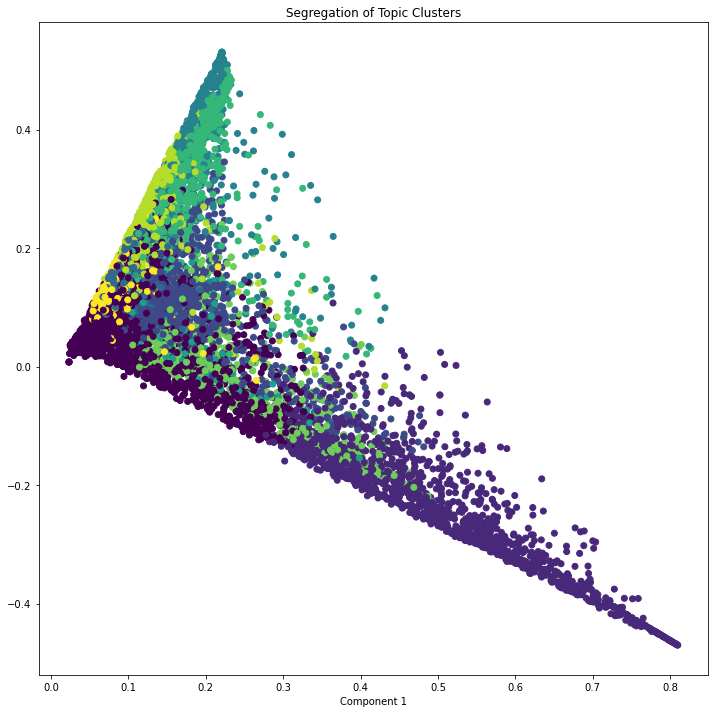

In [17]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# 
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## Kmeans clustering based on LDA topic distribution representation